In [1]:
import pandas as pd

In [2]:
import pandas as pd


df = pd.read_excel("bank.xlsx")

# Print the DataFrame
print(df.head())

      Account No       DATE               TRANSACTION DETAILS  CHQ.NO.  \
0  409000611074' 2017-06-29  TRF FROM  Indiaforensic SERVICES      NaN   
1  409000611074' 2017-07-05  TRF FROM  Indiaforensic SERVICES      NaN   
2  409000611074' 2017-07-18        FDRL/INTERNAL FUND TRANSFE      NaN   
3  409000611074' 2017-08-01   TRF FRM  Indiaforensic SERVICES      NaN   
4  409000611074' 2017-08-16        FDRL/INTERNAL FUND TRANSFE      NaN   

  VALUE DATE  WITHDRAWAL AMT  DEPOSIT AMT  BALANCE AMT  .  
0 2017-06-29             NaN    1000000.0    1000000.0  .  
1 2017-07-05             NaN    1000000.0    2000000.0  .  
2 2017-07-18             NaN     500000.0    2500000.0  .  
3 2017-08-01             NaN    3000000.0    5500000.0  .  
4 2017-08-16             NaN     500000.0    6000000.0  .  


In [6]:
unique_values = df['Account No'].unique()
print(unique_values)

["409000611074'" "409000493201'" "409000425051'" "409000405747'"
 "409000438611'" "409000493210'" "409000438620'" "1196711'" "1196428'"
 "409000362497'"]


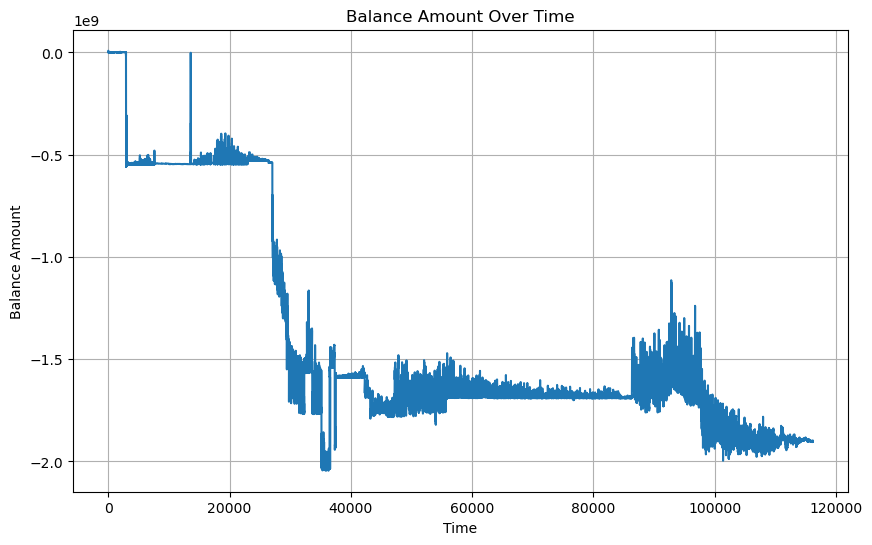

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))  # You can adjust the size as needed
plt.plot(df['BALANCE AMT'][0:-1])  # 'o' specifies the type of marker; you can change this as needed.

plt.title('Balance Amount Over Time')  # You can customize the title
plt.xlabel('Time')  # Assuming the x-axis represents time. Replace as appropriate.
plt.ylabel('Balance Amount')  # Label for the y-axis

plt.grid(True)  # Adds a grid; may be helpful depending on your data
plt.show()  # This will display the plot


# LSTM

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# Load the dataset
file_path = 'bank.xlsx'  # Update this with the actual path to your Excel file
df = pd.read_excel(file_path)

# Normalize the 'BALANCE AMT' column
scaler = MinMaxScaler(feature_range=(0, 1))
df['normalized_balance'] = scaler.fit_transform(df[['BALANCE AMT']])

# Convert 'Account No' to integer indices
unique_accounts = df['Account No'].unique()
account_to_int = {account: i for i, account in enumerate(unique_accounts)}
print(account_to_int)
df['account_index'] = df['Account No'].map(account_to_int)

# Create sequences
def create_sequences(data, seq_length, step):
    xs, ys = [], []
    for i in range(0, len(data) - seq_length, step):
        x = data['normalized_balance'].iloc[i:(i + seq_length)].values
        y = data['account_index'].iloc[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), to_categorical(ys, num_classes=len(unique_accounts))

seq_length = 50  # Number of steps in sequences
step = 1  # Step size

# Apply the function to the dataframe
X, y = create_sequences(df, seq_length, step)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], seq_length, 1))
X_test = np.reshape(X_test, (X_test.shape[0], seq_length, 1))

# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(50),
    Dropout(0.2),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(len(unique_accounts), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping]
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy:.4f}')


{"409000611074'": 0, "409000493201'": 1, "409000425051'": 2, "409000405747'": 3, "409000438611'": 4, "409000493210'": 5, "409000438620'": 6, "1196711'": 7, "1196428'": 8, "409000362497'": 9}
Epoch 1/200
1307/1307 [==============================] - 93s 68ms/step - loss: 0.6965 - accuracy: 0.7236 - val_loss: 0.6205 - val_accuracy: 0.7329
Epoch 2/200
1307/1307 [==============================] - 86s 65ms/step - loss: 0.5312 - accuracy: 0.7785 - val_loss: 1.3984 - val_accuracy: 0.6769
Epoch 3/200
1307/1307 [==============================] - 86s 66ms/step - loss: 0.4181 - accuracy: 0.8227 - val_loss: 0.3631 - val_accuracy: 0.8395
Epoch 4/200
1307/1307 [==============================] - 84s 64ms/step - loss: 0.3599 - accuracy: 0.8438 - val_loss: 0.4390 - val_accuracy: 0.8508
Epoch 5/200
1307/1307 [==============================] - 84s 64ms/step - loss: 0.2990 - accuracy: 0.8687 - val_loss: 0.5947 - val_accuracy: 0.8547
Epoch 6/200
1307/1307 [==============================] - 83s 64ms/step - l

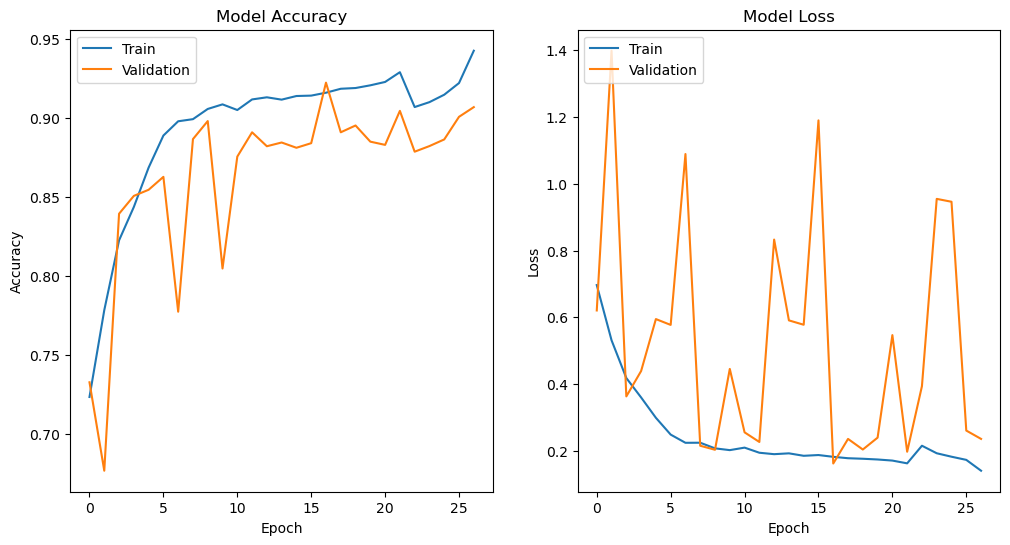

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


# LSTM with Transaction Details

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout, BatchNormalization, concatenate

# Load the dataset
file_path = 'bank.xlsx'
df = pd.read_excel(file_path)

# Normalize the "BALANCE AMT"
scaler = MinMaxScaler(feature_range=(0, 1))
df['normalized_balance'] = scaler.fit_transform(df[['BALANCE AMT']])

# Convert 'TRANSACTION DETAILS' to string and handle NaNs
df['TRANSACTION DETAILS'] = df['TRANSACTION DETAILS'].fillna('unknown').astype(str)

# Tokenize the "TRANSACTION DETAILS"
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['TRANSACTION DETAILS'])
sequences = tokenizer.texts_to_sequences(df['TRANSACTION DETAILS'])
max_sequence_len = max(len(x) for x in sequences)

# Pad the sequences
transaction_details_padded = pad_sequences(sequences, maxlen=max_sequence_len, padding='post')

# One-hot encode the user IDs
unique_accounts = df['Account No'].unique()
account_to_int = {account: i for i, account in enumerate(unique_accounts)}
df['user_id_encoded'] = df['Account No'].map(account_to_int)
y = to_categorical(df['user_id_encoded'])

# Split the dataset (80-20 split)
X_balance_train, X_balance_test, X_transaction_train, X_transaction_test, y_train, y_test = train_test_split(
    df['normalized_balance'], transaction_details_padded, y, test_size=0.2, random_state=42
)

# Reshape the balance data
X_balance_train = np.reshape(X_balance_train.values, (X_balance_train.shape[0], 1, 1))
X_balance_test = np.reshape(X_balance_test.values, (X_balance_test.shape[0], 1, 1))

# Define the model
n_classes = len(unique_accounts)

input_balance = Input(shape=(1, 1))
input_transaction = Input(shape=(max_sequence_len,))

x = Embedding(max_words, 128)(input_transaction)
x = LSTM(50, return_sequences=True)(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = LSTM(50)(x)

y = LSTM(50, return_sequences=True)(input_balance)
y = Dropout(0.2)(y)
y = BatchNormalization()(y)
y = LSTM(50)(y)

combined = concatenate([x, y])

z = Dense(64, activation='relu')(combined)
z = Dropout(0.2)(z)
z = BatchNormalization()(z)
z = Dense(n_classes, activation='softmax')(z)

model = Model(inputs=[input_balance, input_transaction], outputs=z)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit([X_balance_train, X_transaction_train], y_train, epochs=15, batch_size=32, validation_split=0.1)

# Evaluate the model
model.evaluate([X_balance_test, X_transaction_test], y_test)


Epoch 1/10
2615/2615 [==============================] - 48s 17ms/step - loss: 0.2891 - accuracy: 0.8872 - val_loss: 0.1666 - val_accuracy: 0.9323
Epoch 2/10
2615/2615 [==============================] - 41s 16ms/step - loss: 0.1965 - accuracy: 0.9201 - val_loss: 0.1509 - val_accuracy: 0.9343
Epoch 3/10
2615/2615 [==============================] - 42s 16ms/step - loss: 0.1705 - accuracy: 0.9301 - val_loss: 0.1443 - val_accuracy: 0.9351
Epoch 4/10
2615/2615 [==============================] - 40s 15ms/step - loss: 0.1548 - accuracy: 0.9361 - val_loss: 0.1366 - val_accuracy: 0.9437
Epoch 5/10
2615/2615 [==============================] - 40s 15ms/step - loss: 0.1455 - accuracy: 0.9396 - val_loss: 0.1302 - val_accuracy: 0.9450
Epoch 6/10
2615/2615 [==============================] - 44s 17ms/step - loss: 0.1396 - accuracy: 0.9422 - val_loss: 0.1369 - val_accuracy: 0.9389
Epoch 7/10
2615/2615 [==============================] - 42s 16ms/step - loss: 0.1365 - accuracy: 0.9431 - val_loss: 0.1288 -

[0.11278443783521652, 0.9517232179641724]

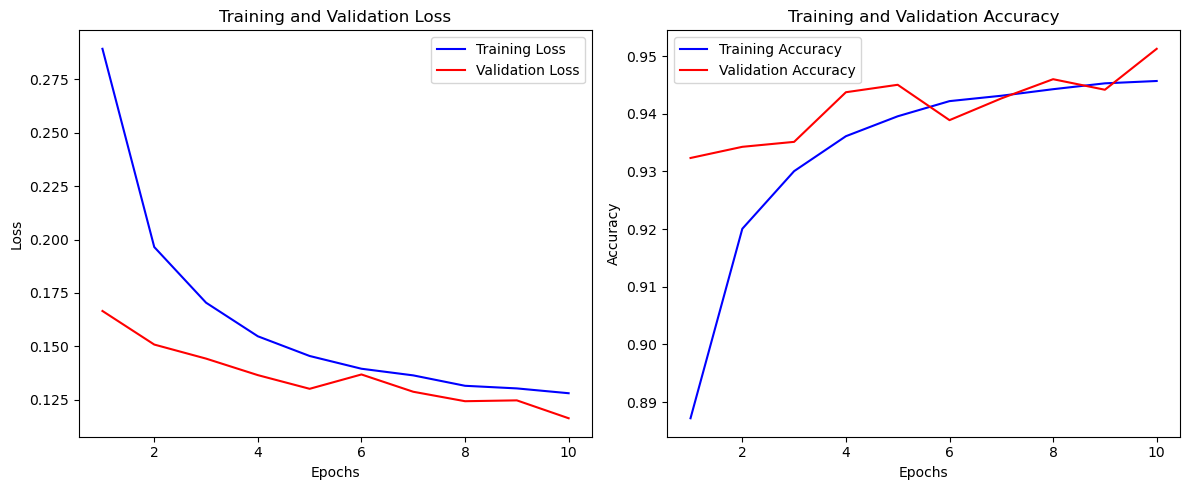

In [14]:
import matplotlib.pyplot as plt

# Extracting loss and accuracy values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plotting training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Bidirectional LSTM

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout, BatchNormalization, concatenate, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Load the dataset
file_path = 'bank.xlsx'
df = pd.read_excel(file_path)

# Normalize the "BALANCE AMT"
scaler = MinMaxScaler(feature_range=(0, 1))
df['normalized_balance'] = scaler.fit_transform(df[['BALANCE AMT']])

# Convert 'TRANSACTION DETAILS' to string and handle NaNs
df['TRANSACTION DETAILS'] = df['TRANSACTION DETAILS'].fillna('unknown').astype(str)

# Tokenize the "TRANSACTION DETAILS"
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['TRANSACTION DETAILS'])
sequences = tokenizer.texts_to_sequences(df['TRANSACTION DETAILS'])
max_sequence_len = max(len(x) for x in sequences)

# Pad the sequences
transaction_details_padded = pad_sequences(sequences, maxlen=max_sequence_len, padding='post')

# One-hot encode the user IDs
unique_accounts = df['Account No'].unique()
account_to_int = {account: i for i, account in enumerate(unique_accounts)}
df['user_id_encoded'] = df['Account No'].map(account_to_int)
y = to_categorical(df['user_id_encoded'])

# Split the dataset (80-20 split)
X_balance_train, X_balance_test, X_transaction_train, X_transaction_test, y_train, y_test = train_test_split(
    df['normalized_balance'], transaction_details_padded, y, test_size=0.2, random_state=42
)

# Reshape the balance data
X_balance_train = np.reshape(X_balance_train.values, (X_balance_train.shape[0], 1, 1))
X_balance_test = np.reshape(X_balance_test.values, (X_balance_test.shape[0], 1, 1))

# Define the model
n_classes = len(unique_accounts)

input_balance = Input(shape=(1, 1))
input_transaction = Input(shape=(max_sequence_len,))

x = Embedding(input_dim=max_words, output_dim=128)(input_transaction)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Bidirectional(LSTM(64))(x)

y = LSTM(50, return_sequences=True)(input_balance)
y = Dropout(0.2)(y)
y = BatchNormalization()(y)
y = LSTM(50)(y)

combined = concatenate([x, y])

z = Dense(64, activation='relu')(combined)
z = Dropout(0.2)(z)
z = BatchNormalization()(z)
z = Dense(n_classes, activation='softmax')(z)

model = Model(inputs=[input_balance, input_transaction], outputs=z)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model with early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

history = model.fit([X_balance_train, X_transaction_train], y_train, epochs=30, batch_size=64, validation_split=0.1, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
model.evaluate([X_balance_test, X_transaction_test], y_test)


Epoch 1/30
1308/1308 [==============================] - 88s 62ms/step - loss: 0.2764 - accuracy: 0.8941 - val_loss: 0.1665 - val_accuracy: 0.9327 - lr: 0.0010
Epoch 2/30
1308/1308 [==============================] - 114s 87ms/step - loss: 0.1795 - accuracy: 0.9266 - val_loss: 0.1467 - val_accuracy: 0.9340 - lr: 0.0010
Epoch 3/30
1308/1308 [==============================] - 113s 86ms/step - loss: 0.1614 - accuracy: 0.9334 - val_loss: 0.1332 - val_accuracy: 0.9443 - lr: 0.0010
Epoch 4/30
1308/1308 [==============================] - 108s 83ms/step - loss: 0.1477 - accuracy: 0.9388 - val_loss: 0.1263 - val_accuracy: 0.9469 - lr: 0.0010
Epoch 5/30
1308/1308 [==============================] - 108s 82ms/step - loss: 0.1423 - accuracy: 0.9400 - val_loss: 0.1432 - val_accuracy: 0.9409 - lr: 0.0010
Epoch 6/30
1308/1308 [==============================] - 112s 85ms/step - loss: 0.1365 - accuracy: 0.9429 - val_loss: 0.1343 - val_accuracy: 0.9431 - lr: 0.0010
Epoch 7/30
1308/1308 [===================

[0.10789977759122849, 0.9561120271682739]

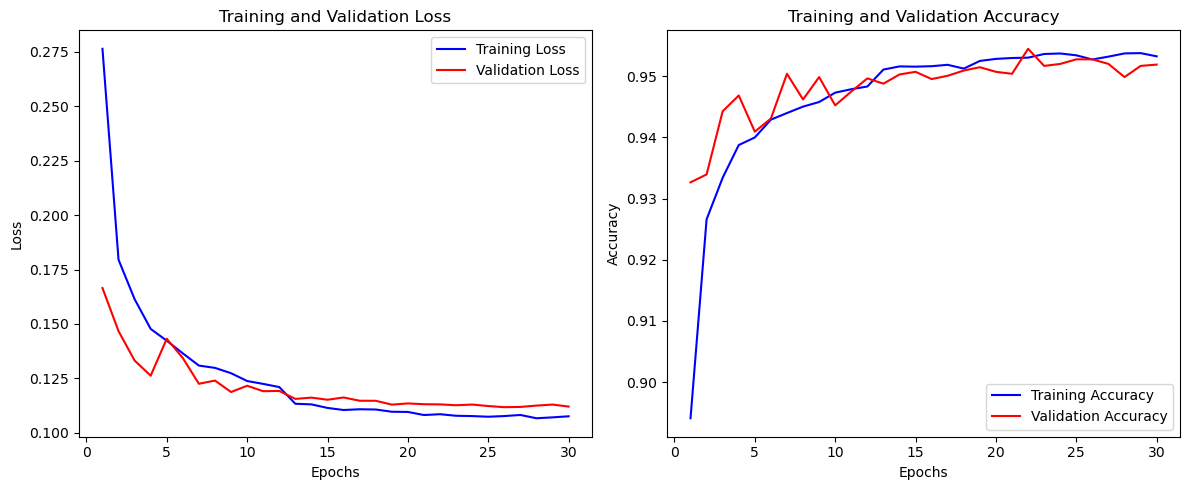

In [17]:
import matplotlib.pyplot as plt

# Extracting loss and accuracy values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plotting training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
